In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 170M/170M [00:04<00:00, 42.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    losses = []
    start_time = time.time()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    training_time = time.time() - start_time
    return losses, training_time

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


In [ ]:
model_adam = SimpleCNN().to(device)
model_adamw = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
adam_optimizer = optim.Adam(model_adam.parameters(), lr=0.001)
adamw_optimizer = optim.AdamW(model_adamw.parameters(), lr=0.001)



Training with Adam:
Epoch [1/10], Loss: 1.4927
Epoch [2/10], Loss: 1.1103
Epoch [3/10], Loss: 0.9487
Epoch [4/10], Loss: 0.8303
Epoch [5/10], Loss: 0.7432
Epoch [6/10], Loss: 0.6596
Epoch [7/10], Loss: 0.5680
Epoch [8/10], Loss: 0.4770
Epoch [9/10], Loss: 0.4011
Epoch [10/10], Loss: 0.3133
Adam Training Time: 91.95 seconds
Adam Test Accuracy: 71.17%

Training with AdamW:
Epoch [1/10], Loss: 1.4878
Epoch [2/10], Loss: 1.1029
Epoch [3/10], Loss: 0.9454
Epoch [4/10], Loss: 0.8187
Epoch [5/10], Loss: 0.7240
Epoch [6/10], Loss: 0.6202
Epoch [7/10], Loss: 0.5291
Epoch [8/10], Loss: 0.4308
Epoch [9/10], Loss: 0.3414
Epoch [10/10], Loss: 0.2588
AdamW Training Time: 83.24 seconds
AdamW Test Accuracy: 71.62%


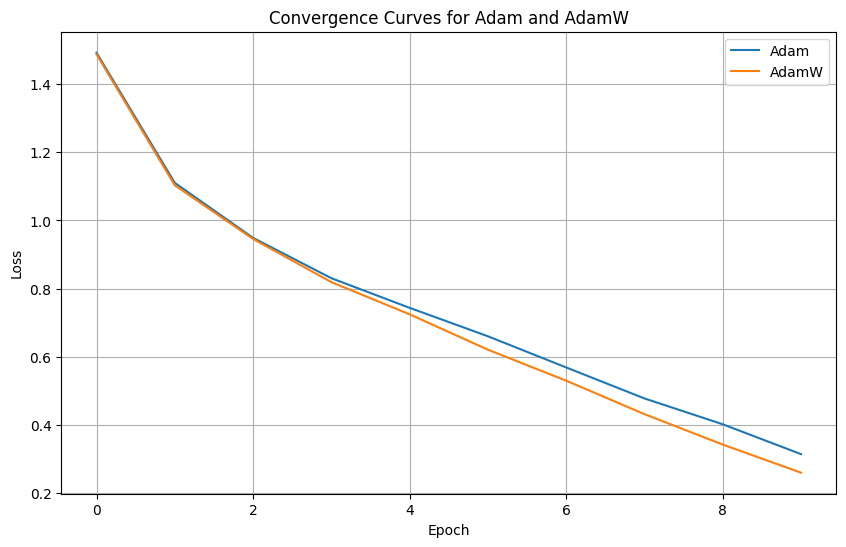

In [ ]:
print("Training with Adam:")
adam_losses, adam_time = train_model(model_adam, train_loader, criterion, adam_optimizer, device)
adam_accuracy = evaluate_model(model_adam, test_loader, device)
print(f"Adam Training Time: {adam_time:.2f} seconds")
print(f"Adam Test Accuracy: {adam_accuracy:.2f}%")

print("\nTraining with AdamW:")
adamw_losses, adamw_time = train_model(model_adamw, train_loader, criterion, adamw_optimizer, device)
adamw_accuracy = evaluate_model(model_adamw, test_loader, device)
print(f"AdamW Training Time: {adamw_time:.2f} seconds")
print(f"AdamW Test Accuracy: {adamw_accuracy:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(adam_losses, label="Adam")
plt.plot(adamw_losses, label="AdamW")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Convergence Curves for Adam and AdamW")
plt.legend()
plt.grid()
plt.show()